# Re-analysing ILL Y(Mn1-xFex)2 Data

This data was collected 15th July, 2000 (the logbook says 2002, I have no idea why, 2000 sounds right).  In those days, there was no event mode, so this analysis creates events by randomly smapling the histograms.  This is a good test of the method, because we already know what the traditional analysis shows, and we should be able to reproduce the result.

## Histogram Functions

The first step is to recreate a few of the basic workflow functions before we re-sample the histograms as events.

Some curiosities:
* The LAMP code s_normalise.pro, which normalises the data to monitor counts etc, multiplies the run counts by 1000 before dividing by the monitor counts.  This is odd.
* My radial average code is almost precisely 0.5 times the output of the ILL code, neglecting some small sampling errors and systematics.  A factor of 2 difference is always suspicious but I can't see where it is.  I use the same algorithm as in LAMP basically.
* If I normalise by monitor counts like in LAMP then the scaling factor difference is almost exactly pi * root(2), maybe this is a solid angle correction?
* It appears that the LAMP code from 20 years ago doesn't actually pay any attention to the perspex ("water") run (there is SANS in it and so a systematic error) or the cadmium run (the background is so small anyway you can just ignore it).
* My fits with lmfit produce different parameters with the same data.
* It looks like the LAMP code does not shift the x values to the histogram bin centre, but rather keeps the low-x edge.


In [73]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm



def plot_detector_map(data, log_scale=True):
    if log_scale:
        data = np.log(data)
    plt.imshow(data,  interpolation='nearest', cmap=cm.viridis)
    
def detector_distance_from(num):
    # Returns detector distance value from run
    path = "data/ill/d11/ymnfe2/"
    fnum = str(num).zfill(6)
    fullname = path + fnum
    
    datafile = open(fullname, 'r')
    lines=datafile.readlines()
    datafile.close()
            
    comment_block_length = 26
        
    detector_distance_line_index = [37+comment_block_length]
    detector_distance_line = [lines[i].strip() for i in detector_distance_line_index]
    detector_distance_index = 3
    det = np.float_( detector_distance_line[0].split("  ")[detector_distance_index] )
    
    return(det)

    
def wavelength_from(num):
    # Returns wavelength value from run
    path = "data/ill/d11/ymnfe2/"
    fnum = str(num).zfill(6)
    fullname = path + fnum
    
    
    datafile = open(fullname, 'r')
    lines=datafile.readlines()
    datafile.close()
 
    comment_block_length = 26
        
    wavelength_line_index = [44+comment_block_length]
        
    wavelength_line = [lines[i].strip() for i in wavelength_line_index]
        
    wavelength_index = 2
    wavelength = np.float_( wavelength_line[0].split("  ")[wavelength_index] )
    
    return wavelength
    
def temperature_from(num):
    path = "data/ill/d11/ymnfe2/"
    fnum = str(num).zfill(6)
    fullname = path + fnum
    
    
    datafile = open(fullname, 'r')
    lines=datafile.readlines()
    datafile.close()
        
    comment_block_length = 26
    temperature_line_index = [40+comment_block_length]
    temperature_line = [lines[i].strip() for i in temperature_line_index]        
    temperature_index = 0
        
    temp = np.float_( temperature_line[0].split("  ")[temperature_index] )

    return(temp)

    
def read_run(num, info=False, plot=False):
    # Reads an individual run in ancient ILL D11 format
    
    path = "data/ill/d11/ymnfe2/"
    fnum = str(num).zfill(6)
    fullname = path + fnum
    print(fullname)
    
    
    datafile = open(fullname, 'r')
    lines=datafile.readlines()
    meta_elements = [25, 26]
    meta = [lines[i].strip() for i in meta_elements]
        
    comment_block_length = 26
        
    detector_line_index = [34+comment_block_length]
    detector_distance_line_index = [37+comment_block_length]
    temperature_line_index = [40+comment_block_length]
    wavelength_line_index = [44+comment_block_length]
    collimation_line_index = [45+comment_block_length]
        
    detector_line = [lines[i].strip() for i in detector_line_index]
    detector_distance_line = [lines[i].strip() for i in detector_distance_line_index]
    temperature_line = [lines[i].strip() for i in temperature_line_index]
    wavelength_line = [lines[i].strip() for i in wavelength_line_index]
    collimation_line = [lines[i].strip() for i in collimation_line_index]
        
    detector_sum_index = 3
    monitor_sum_index = 4
    detector_distance_index = 3
    temperature_index = 0
    wavelength_index = 2
    collimation_index = 2
        
        
    detector_sum = np.float_( detector_line[0].split("  ")[detector_sum_index] )
    monitor_sum = np.float_( detector_line[0].split("  ")[monitor_sum_index] )
    det = np.float_( detector_distance_line[0].split("  ")[detector_distance_index] )
    temp = np.float_( temperature_line[0].split("  ")[temperature_index] )
    wavelength = np.float_( wavelength_line[0].split("  ")[wavelength_index] )
    collimation = np.float_( collimation_line[0].split("  ")[collimation_index] )
    
    datafile.close()

        
    if info:
        print(meta[0])
        print(meta[1])
        
        print("Det. sum:", detector_sum)
        print("Mon. sum:", monitor_sum)
        print("Det. distance:", det)
        print("Temp:", temp)
        print("Wavelength:", wavelength)
        print("Collimation:", collimation)

    
    
    # Get some info on run
    datafile = open(fullname, 'r')
    
    # Legacy ILL data for D11 has 118 header rows
    lines=datafile.readlines()[118:]#skiprows=118)
    

    
    datafile.close()
    
    
    # The data is a 64x64 detector, but the histo
    # counts are recorded with 10 columns in sequence
    # Probably a fortran thing from back in the day
    
    data = []
    
    for line in lines:
        data += line.strip().split(" ")
        
    # Now we have each histo entry space separated
    # but we also have a lot of empty values
    # Each space character was stored.  Remove empty entries
    sdata = list(filter(None, data))
    
    # Convert strings to numpy array of floats
    ndata = np.float_(sdata)
    
    # Re-arrange into 64x64 grid of detector pixels
    ndata = ndata.reshape(64,64)
    
    # plot if necessary
    if plot:
        plot_detector_map(ndata)
    
    # It looks like this is the correct orientation,
    # with gravity downwards, in plt.imshow.  No rotation 
    # is required.
    # This is an array with [y, x] indices starting top-left
    
    return ndata, detector_sum, monitor_sum


def read_sum(run1, run2, plot=True):
    # Reads multiple runs and sums up the data
    
    data, detector_sum, monitor_sum = read_run(run1, plot=False, info=False)
    
    for run in range(run1+1, run2+1):
        new_data, new_dsum, new_msum = read_run(run, plot=False, info=False)
        data = data + new_data
        detector_sum = detector_sum + new_dsum
        monitor_sum = monitor_sum + new_msum
        
    if plot:
        plot_detector_map(data)
    
    return data, detector_sum, monitor_sum
    
    
    
def event_resample(data, detector_distance, wavelength, beam_centre):
    # Takes D11 2d histogram, detector distance, and wavelength, and resamples
    # events from the matrix assuming all neutrons are at a central point in the
    # pixel
    
    # This is the alternative method to the radial average (see below) which
    # preseves the histogram structure
    
    # Note that pixels are arranged in (y, x) order, NOT (x, y)
    
    opp = np.zeros_like(data)
    
    for iy in range(0, 64):
        for ix in range(0, 64):
            yval = iy - beam_centre[1]
            xval = ix - beam_centre[0]
            opp[iy, ix] = np.sqrt(yval**2.0 + xval**2.0)
    
    tanq = 0.01 * opp / detector_distance
    two_theta = np.arctan(tanq)
    
    theta = 0.5 * two_theta
    
    qval = 4.0 * np.pi * np.sin(theta) / wavelength
    
    
    return qval
    
def bleed_mask(mask):
    # takes mask data and bleeds it one pixel over

    # Bleed in y direction positive
    for iy in range(0, 64):
        for ix in range(0, 64):
            if iy < 63:
                if mask[iy+1, ix] < 0.5:
                    mask[iy, ix] = 0.0
    
    # Bleed in y direction negative
    for iy in range(63, -1, -1):
        for ix in range(0, 64):
            if iy > 0:
                if mask[iy-1, ix] < 0.5:
                    mask[iy, ix] = 0.0
                    
    # Bleed in x direction positive
    for iy in range(0, 64):
        for ix in range(0, 64):
            if ix < 63:
                if mask[iy, ix+1] < 0.5:
                    mask[iy, ix] = 0.0
                    
    # Bleed in x direction negative
    for iy in range(0,64):
        for ix in range(63, -1, -1):
            if ix > 0:
                if mask[iy, ix-1] < 0.5:
                    mask[iy, ix] = 0.0
    
    return mask

def make_mask(water):
    # uses a water run to make a mask.  Manually masks edges of detector
    # Finds the beamstop area and the detector boundaries by average
    # comparison
    
    mask = np.ones_like(water)
    
    left_panel = water[12:50,1:20]
    right_panel = water[12:50,1:61]
    top_panel = water[1:12,20:50]
    bot_panel = water[50:61,20:50]
    trimmed = np.concatenate((\
        left_panel.flatten(),\
        right_panel.flatten(),\
        top_panel.flatten(),\
        bot_panel.flatten()))
    
    mask_mean = np.mean(trimmed)
    mask_stddev = np.std(trimmed)
        
    threshold = mask_mean - mask_stddev
    

    
    
    fail = water < threshold
    
    mask[fail] = 0.0    

    mask = bleed_mask(mask)

    # manual edges
    mask[:,0]=0.0
    mask[0,:]=0.0
    mask[:,63] = 0.0
    mask[63,:] = 0.0
    
    plot_detector_map(mask, log_scale=False)
    
    return mask
    

def radial_average(data, detector_distance, wavelength, beam_centre, nbins=64, geometric_norm=True, cleanup=True, xshift=False, plot=True, xmin=None, xmax=None, ymin=None, ymax=None):
    # Radially averages the data and converts to Q
    
    opp = np.zeros_like(data)
    
    err_data = np.sqrt(data)
    
    for iy in range(0, 64):
        for ix in range(0, 64):
            yval = iy - beam_centre[1]
            xval = ix - beam_centre[0]
            opp[iy, ix] = np.sqrt(yval**2.0 + xval**2.0)
    
    tanq = 0.01 * opp / detector_distance
    two_theta = np.arctan(tanq)
    
    theta = 0.5 * two_theta
    
    qval = 4.0 * np.pi * np.sin(theta) / wavelength
    qmin = np.amin(qval)
    qmax = np.amax(qval)
    
    bins = np.linspace(qmin, qmax, nbins)
    
    # The normalisation factor for each bin is the radial average
    # of the q values (that just counts how many pixels fall in
    # each bin) if we normalise by pixel, otherwise geometric_norm
    
    bin_width = bins[1]-bins[0]
        
    if geometric_norm:
        # We normalise geometrically - this normalisation factor is what we'd use in event mode
        # However, this seems to result in LAMP / (pi * sqrt(2))
        #geom = data / (2.0 * np.pi * qval)
        
        # This normalisation factor is scaled by some values, but I'm not entirely sure where they come from.
        #.      difference between circle areas / not sure about pi, the The root 2 comes from square grid
        circle_area_diff = (4.0 * np.pi * bin_width * qval)
        square_approx = np.sqrt(2.0) # difference between area of a square and a circle?
        no_idea_wtf = np.pi # This is obviously there from looking at the data but no clue why
        
        norm = circle_area_diff / (no_idea_wtf * square_approx)
        geom = data / norm
        err_geom = err_data / norm
        #err_data = err_data / norm # err_data / norm
        hst = np.histogram(qval, bins=bins, weights = geom)
        err_hst = np.histogram(qval, bins=bins, weights = err_geom)
        #err_hst = np.sqrt(hst[0])
        
    else:
        # we normalise numerically by counting pixels in each bin - this is the traditional way to do it.  However, this seems to result
        # in 0.5 * LAMP
        norm_hst = np.histogram(qval, bins=bins)
        err_norm = np.sqrt(norm_hst[0])
        
        hst = np.histogram(qval, bins=bins, weights = data)
        err_hst = np.histogram(qval, bins=bins, weights = err_data)
        
        # The mistake here is that you are essentially 
        # dividing by a number, so the error bar should be propagated
        # as a division, not just the sqrt
        
    #err = err[0]
    #err = np.sqrt(hst[0])
    
    
    
    xvals = hst[1]
    
    # Shift the x values to bin-centre
    if xshift:
        print("Shifting x")
        dx = xvals[1]-xvals[0]
        xvals = xvals + 0.5*dx
    else:
        print("Not shifting x")
    
    xplot = xvals[:-1]
    
    if geometric_norm:
        yplot = hst[0]
        err = err_hst[0]
    else:
    # Normalise by pixel:
        yplot = hst[0] / norm_hst[0]
        err = np.sqrt(yplot * (np.square(err_hst[0]/hst[0]) + np.square(err_norm / norm_hst[0])))
        
    
    
    
    if plot:    
        #plt.plot(xplot, yplot, ls='None', marker='o')
        plt.errorbar(xplot, yplot, yerr=err, ls='None', marker='o')
        plt.yscale('log')
        plt.xscale('log')
        if xmin != None and xmax != None:
            plt.xlim([xmin, xmax])
        if ymin != None and ymax != None:
            plt.ylim([ymin, ymax])
            
    # Trim the data to specified ranges
    if xmin != None and xmax != None:
        trim_mask_min = xplot > xmin
        trim_mask_max = xplot < xmax
        trim_mask = trim_mask_min & trim_mask_max
        
        xplot = xplot[trim_mask]
        yplot = yplot[trim_mask]
        err = err[trim_mask]
        
    # Remove any points that are zero if cleanup is true
    if cleanup:
        clean_mask = yplot > 0.0
        xplot = xplot[clean_mask]
        yplot = yplot[clean_mask]
        err = err[clean_mask]
    
    return xplot, yplot, err
    
    
    
def apply_mask(data, mask, plot=True):
    # masks out the data and returns cleaned data
    new_data = data * mask
    
    if(plot):
        plot_detector_map(new_data)
    
    return new_data



def norm_water(data, water, data_mon=1.0, water_mon=1.0, divide=False, verbose=False, plot=True):
    # normalises the detector response efficiency based on water run
    
    num_pixels = np.float_(np.sum(water > 0.0))
    
    nanmask = water == 0.0
    
    water_scale = water_mon / data_mon
    
    water = water / water_scale
    
    water_sum = np.sum(water)
    
    water = num_pixels * water / water_sum
    
    if divide:
        water[nanmask] = 1.0
        new_data = data / water
    else:
        new_data = data * water

    
    if verbose:
        print("water scale:", water_mon / data_mon)
        np.set_printoptions(threshold=np.inf)
        print("water norm:")
        print(water)
        np.set_printoptions(threshold=1000)
    
    if(plot):
        plot_detector_map(new_data)
    
    return new_data
    
    
    
    
    
def find_centre(data):
    # Uses a TRANSMISSION RUN to find the beam centre
    # beamcentre.pro in LAMP does a least-squares fit to a gaussian
    # this code does two MLE estimates of gaussian, one for each component
    
    # Weighted mean of pixel coordinate map
    
    # Arrays are indexed [y, x] with origin in top left
    # as plotted in matplotlib imshow

    
    yint = np.sum(data, axis=1) 
    xint = np.sum(data, axis=0)
    
    yint_sum = np.sum(yint)
    xint_sum = np.sum(xint)
        
    yint = yint / yint_sum
    xint = xint / xint_sum
    
    pixval = np.arange(0, 64)
    
    weightedx = pixval * yint
    weightedy = pixval * xint
    
    xcentre = np.sum(weightedx)
    ycentre = np.sum(weightedy)
    
    # We return (x, y) location, but code elsewhere keeps track that the 
    # arrays are arranged (y, x) for imshow...
    return np.array([xcentre, ycentre])
        

def calculate_transmission(sample, air, sample_mon, air_mon, verbose=True):
    
    # D11 has 3 attenuators with the following factors according to the website:
    #fa=8.53 (att 1)
    #fa=26.40 (att 2)
    #fa=68.47 (att 3)
    
    spot_max = np.amax(air)
    spot_region = air > 0.5*spot_max
    
    #spot_max = np.amax(sample)
    #spot_region = sample > 0.0#5*spot_max
    
    air_clip = air[spot_region]
    sample_clip = sample[spot_region]
    
    airsum = np.sum(air_clip)
    ssum = np.sum(sample_clip)
    
    airsum_mon = airsum / air_mon
    ssum_mon = ssum / sample_mon
    
    transmission_mon = ssum_mon / airsum_mon
    transmission = ssum / airsum
    
    if verbose:
        print("airsum", airsum)
        print("ssum", ssum)
        print("airsum_mon", airsum_mon)
        print("ssum_mon", ssum_mon)
        print("transmission_mon", transmission_mon)
        print("transmission", transmission)
    
    return transmission_mon
    

In [2]:
test_a = 1.0
circle_area = 0.25 * np.pi * test_a**2.0
square_area = test_a * test_a

ratio = circle_area / square_area
print(ratio)
print(1.0/np.sqrt(2.0))
print(np.pi / 4.0)

0.7853981633974483
0.7071067811865475
0.7853981633974483


data/ill/d11/ymnfe2/006314
data/ill/d11/ymnfe2/006315
21565.0 21565.0 1199998.0


/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_1917/3378788447.py:9: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)


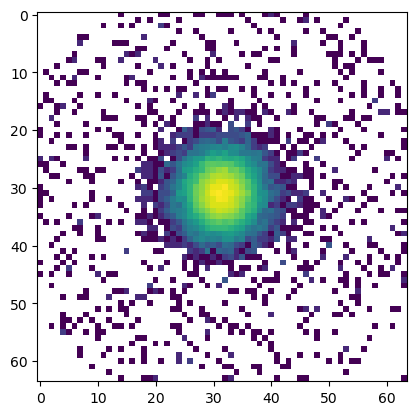

In [4]:
sample_trans, sample_trans_sum, sample_trans_mon = read_sum(6314, 6315, plot=True)
print(np.sum(sample_trans), sample_trans_sum, sample_trans_mon)

data/ill/d11/ymnfe2/006018
Cywinski  ymnfe2                                 5-32-60877 perspex trans
15-JUN-00 13:43:33  15-JUN-00 13:46:39
Det. sum: 264240.0
Mon. sum: 599999.0
Det. distance: 10.0
Temp: 9999.99902
Wavelength: 10.0037508
Collimation: 10.5
264240.0 264240.0 599999.0


/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_1917/3378788447.py:9: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)


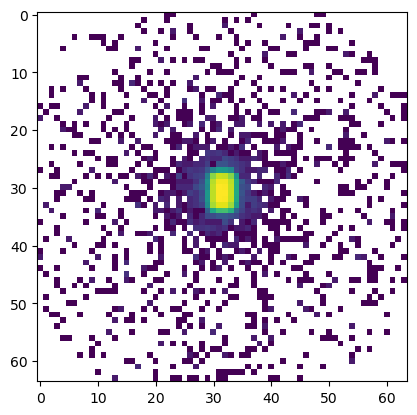

In [5]:
empty_trans, empty_trans_sum, empty_trans_mon = read_run(6018, plot=True, info=True)
print(np.sum(empty_trans), empty_trans_sum, empty_trans_mon)

In [6]:
transmission = calculate_transmission(sample_trans, empty_trans, sample_trans_mon, empty_trans_mon)
print(transmission)

airsum 166757.0
ssum 3358.0
airsum_mon 0.27792879654799424
ssum_mon 0.0027983379972299953
transmission_mon 0.010068542849775422
transmission 0.020137085699550843
0.010068542849775422


In LAMP, we measured 0.0108, this is good.

data/ill/d11/ymnfe2/006346


/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_1917/3378788447.py:9: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)


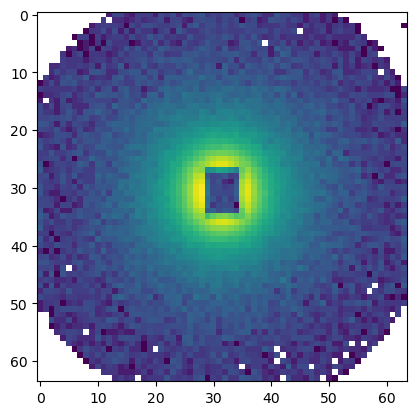

In [7]:
nuclear, non1, nuclear_mon = read_run(6346, plot=True)

data/ill/d11/ymnfe2/006025


/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_1917/3378788447.py:9: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)


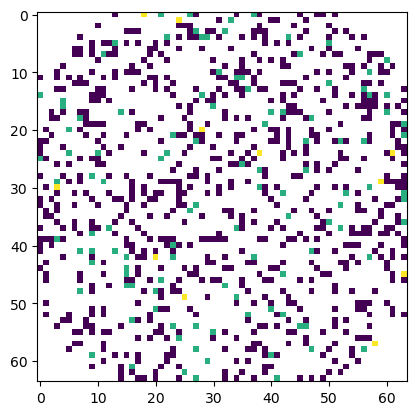

In [8]:
cadmium, non1, non2 = read_run(6025, plot=True)

data/ill/d11/ymnfe2/006010
data/ill/d11/ymnfe2/006011
data/ill/d11/ymnfe2/006012
data/ill/d11/ymnfe2/006013
data/ill/d11/ymnfe2/006014
data/ill/d11/ymnfe2/006015
data/ill/d11/ymnfe2/006016
data/ill/d11/ymnfe2/006017


/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_1917/3378788447.py:9: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)


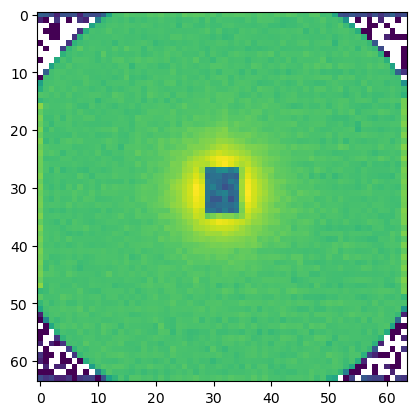

In [9]:
water, detsum, water_mon = read_sum(6010, 6017)
#water = water - cadmium

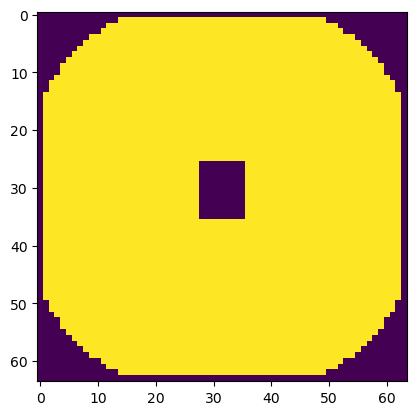

In [10]:
detector_mask = make_mask(water)

In [11]:
ctr_data, ss, mon = read_run(6314, info=True)
print(ss)
beam_centre = find_centre(ctr_data)
print(beam_centre)

data/ill/d11/ymnfe2/006314
Cywinski  ymnfe2                                 5-32-60877 YMnFe0.6 trans
18-JUN-00 22:18:36  18-JUN-00 22:21:43
Det. sum: 12405.0
Mon. sum: 599999.0
Det. distance: 9.9989996
Temp: 101.439003
Wavelength: 9.99982071
Collimation: 10.5
12405.0
[30.92261185 31.36130593]


/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_1917/3378788447.py:9: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)


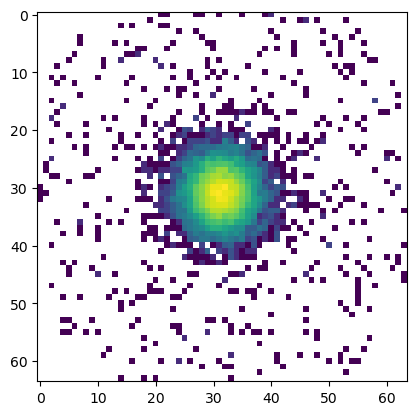

In [12]:
plot_detector_map(ctr_data)

In [13]:
realdat, detsum, data_mon = read_run(6316)
#realdat = realdat - cadmium
#realdat = realdat - nuclear

data/ill/d11/ymnfe2/006316


/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_1917/3378788447.py:9: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)


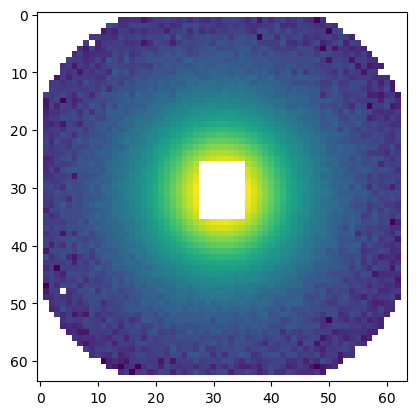

In [14]:
realdat_masked = apply_mask(realdat, detector_mask)

/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_1917/3378788447.py:9: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)


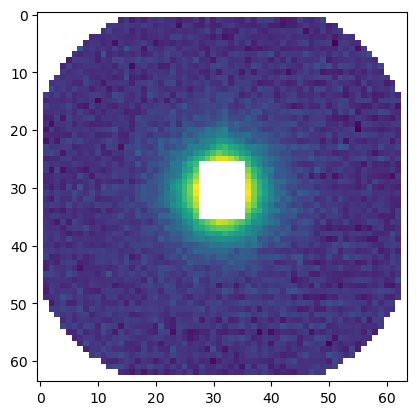

In [15]:
water_masked = apply_mask(water, detector_mask)

/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_1917/3378788447.py:9: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)


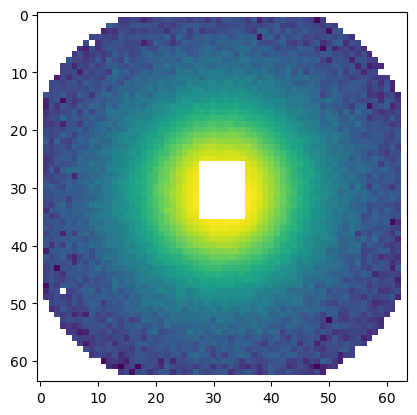

In [16]:
norm_realdat = norm_water(realdat_masked, water_masked, data_mon=data_mon, water_mon=water_mon)
norm_divide = norm_water(realdat_masked, water_masked, data_mon=data_mon, water_mon=water_mon, divide=True)

The following treatment reconstructs the ILL data using IDL (almost):
* No cadmium subtraction
* No detector efficiency / water calibration
* No shift in x values
* 54 data points in radial average

The anomalous feature of this is the appearance of a factor of 0.5 (or 2.0) in the scaling.  Must investigate.  If I duplicate exactly what happens in LAMP - multiply by 1000 then divide by monitor counts - then I end up needing a factor of 4.5, which is close to pi * root(2), as shown in the code below.

In [17]:
np.pi * np.sqrt(2.0)

4.442882938158366

Not shifting x
Not shifting x
Not shifting x
Not shifting x
Tail should be roughly at 13.0


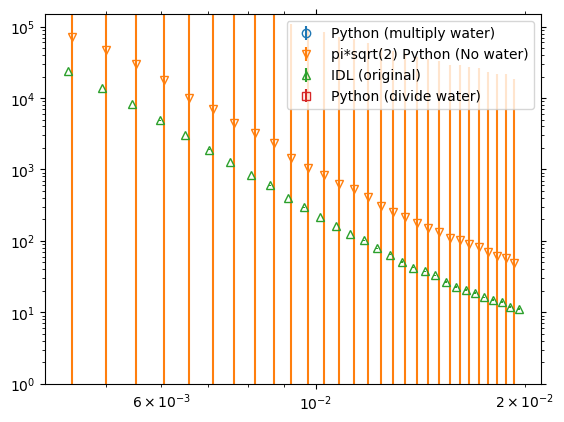

In [18]:
nbins=54

xmin = 0.004
xmax = 0.0195

spec = radial_average(norm_realdat, detector_distance_from(6010), wavelength_from(6010), beam_centre, nbins=nbins, xshift=False, plot=False, xmin=xmin, xmax=xmax)#0.02, ymin=1.0, ymax=10000.0)
divide =radial_average(norm_divide, detector_distance_from(6010), wavelength_from(6010), beam_centre, nbins=nbins, xshift=False, plot=False, xmin=xmin, xmax=xmax)

#check from existing data
old_data = np.loadtxt("/Users/phillipbentley/Experimental_Work/PhD/y(mnfe)2/SANS/xp6/ymnfep6_0.dat", unpack=True,max_rows=30)


# Here is the factor of 2 - use with geometric_norm=False, also gives correct error bars
geometric_norm=False
nowater=radial_average(realdat_masked, detector_distance_from(6010), wavelength_from(6010), beam_centre, geometric_norm=geometric_norm, nbins=nbins, xshift=False, plot=False, xmin=xmin, xmax=xmax)
scalewatery = 2.0*nowater[1]
scalewaterx = nowater[0]
scalewatere = 2.0*nowater[2]
labeltext="2x Python (No water)"

# If I follow what happens in LAMP, and use geometric_norm=True, then it's a factor of 4.5 - maybe pi * root(2)?
# You can comment this out if necessary to check the factor of 2 above
# The geometric norm thing seems to produce the wrong error bars - need to fix that.
geometric_norm=True
nowater=radial_average(realdat_masked, detector_distance_from(6010), wavelength_from(6010), beam_centre, geometric_norm=geometric_norm, nbins=nbins, xshift=False, plot=False, xmin=xmin, xmax=xmax)
#scalewatery = np.pi * np.sqrt(2.0) * 1000.0 * nowater[1] / data_mon
# Moving that correction into the radial average code we can do:
scalewatery = 1000.0 * nowater[1] / data_mon
scalewatery = np.pi * np.sqrt(2.0) * nowater[1] / data_mon
scalewatere = np.pi * np.sqrt(2.0) * 1000.0 * nowater[2] / data_mon
# That seems to work, so I have some normalisation here only to fix
labeltext="pi*sqrt(2) Python (No water)"


fig, ax = plt.subplots()
ax.errorbar(spec[0], spec[1], spec[2], fmt='o', mfc='none', label="Python (multiply water)")
ax.errorbar(scalewaterx, scalewatery, scalewatere, fmt='v', mfc='none', label=labeltext)
ax.errorbar(old_data[0], old_data[1], old_data[2], fmt='^', mfc='none', label="IDL (original)")
ax.errorbar(divide[0], divide[1], divide[2], fmt='s', mfc='none', label="Python (divide water)")
ax.tick_params(top=True, right=True, which='both')
ax.set_xscale('log')
ax.set_yscale('log')
#plt.xlim([0.005, 0.023])
plt.ylim([1.0, 150000.0])
ax.legend()


print("Tail should be roughly at", realdat_masked[32,61])

In [19]:
print(old_data[0][0])
print(scalewaterx[0])
print()
print(old_data[2][0])
print(scalewatere[0])
print()
print(old_data[2][20])
print(scalewatere[20])
print(data_mon)

0.004399
0.004465250851831632

41.061459
730444.9205579625

0.692626
32558.141520183097
3000000.0


Not shifting x
Not shifting x
41.061459
164.40787000810369
31.68587129156906

0.442074
5.258116147574743
2.0252329633350312

0.0003333333333333333


/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_1917/2709065521.py:382: RuntimeWarning: invalid value encountered in divide
  err = np.sqrt(yplot * (np.square(err_hst[0]/hst[0]) + np.square(err_norm / norm_hst[0])))


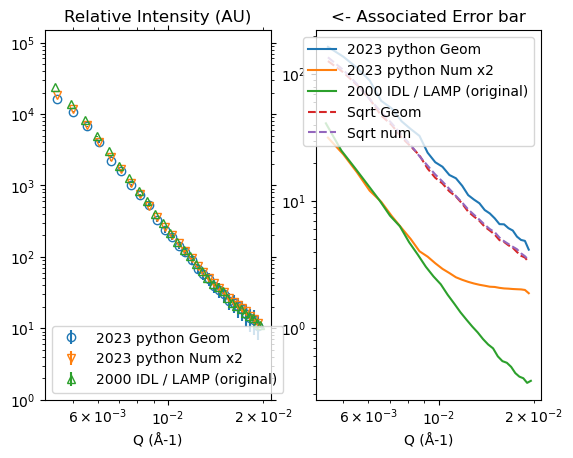

In [74]:
geometric = radial_average(realdat_masked, detector_distance_from(6010), wavelength_from(6010), beam_centre, geometric_norm=True, nbins=nbins, xshift=False, plot=False, xmin=xmin, xmax=xmax)
numeric = radial_average(realdat_masked, detector_distance_from(6010), wavelength_from(6010), beam_centre, geometric_norm=False, nbins=nbins, xshift=False, plot=False, xmin=xmin, xmax=xmax)

geometric_x = geometric[0]
geometric_y = geometric[1] / data_mon #* np.pi * np.sqrt(2.0) / data_mon
geometric_e = geometric[2] / data_mon #* 4.0 * np.pi)# * np.pi * np.sqrt(2.0) ) # / data_mon


numeric_x = numeric[0]
numeric_y = 2.0 * numeric[1]
numeric_e = 2.0 * numeric[2]

root_geom = np.sqrt(geometric_y)
root_num = np.sqrt(numeric_y)

fig, ax = plt.subplots(1,2)
ax[0].errorbar(geometric_x, geometric_y, geometric_e, fmt='o', mfc='none', label="2023 python Geom")
ax[0].errorbar(numeric_x, numeric_y, numeric_e, fmt='v', mfc='none', label="2023 python Num x2")
ax[0].errorbar(old_data[0], old_data[1], old_data[2], fmt='^', mfc='none', label="2000 IDL / LAMP (original)")
ax[0].tick_params(top=True, right=True, which='both')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Q (Å-1)')
ax[0].set_title('Relative Intensity (AU)')
#plt.xlim([0.005, 0.023])
ax[0].set_ylim([1.0, 150000.0])
ax[0].legend()

ax[1].plot(geometric_x, geometric_e, label="2023 python Geom")
ax[1].plot(numeric_x, numeric_e, label="2023 python Num x2")
ax[1].plot(old_data[0], old_data[2], label="2000 IDL / LAMP (original)")
ax[1].plot(geometric_x, root_geom, ls='--', label="Sqrt Geom")
ax[1].plot(numeric_x, root_num, ls='--', label="Sqrt num")
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Q (Å-1)')
ax[1].set_title('<- Associated Error bar')
ax[1].legend()

print(old_data[2,0])
print(geometric_e[0])
print(numeric_e[0])
print()
print(old_data[2,25])
print(geometric_e[25])
print(numeric_e[25])
print()
print(1000.0 / data_mon)


[[Model]]
    Model(emulsion_no_bg)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 29
    # variables        = 4
    chi-square         = 3.3225e-11
    reduced chi-square = 1.3290e-12
    Akaike info crit   = -789.355687
    Bayesian info crit = -783.886504
    R-squared          = 1.00000000
[[Variables]]
    aa:  9.19542364 +/- 291.148387 (3166.23%) (init = 0.0023)
    kk:  0.02872854 +/- 1.48570460 (5171.53%) (init = 0.02)
    bb:  1.77596621 +/- 0.87917868 (49.50%) (init = 200)
    cc:  0.01191912 +/- 0.00171607 (14.40%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(bb, cc) = -0.9727
    C(aa, kk) = -0.9576
    C(kk, bb) = -0.9399
    C(kk, cc) = +0.8724
    C(aa, bb) = +0.8338
    C(aa, cc) = -0.7534
zeta: 6.711342229190456e-05
err: 3.460060963087012e-05


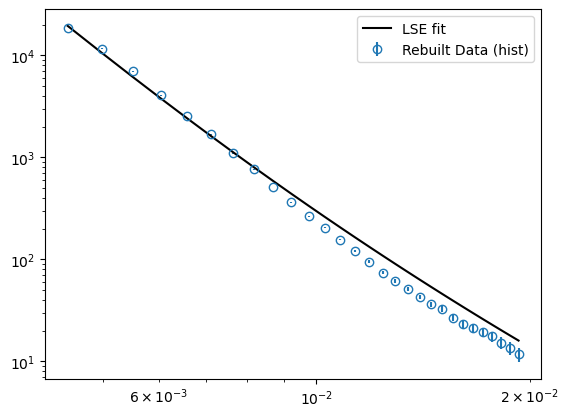

In [75]:
from lmfit import Model

cscale = 1.0E-8
bscale = 1.0E-6
ascale = 1.0E-4

def teubner(x, bb, cc, bg):
    first = bscale * bb / x**4.0
    second = cscale * cc / x**6.0
    return first + second + bg

def emulsion_no_bg(x, aa, kk, bb, cc):
    first = ascale * aa / (kk*kk + x*x)
    second = bscale * bb / x**4.0
    third = cscale * cc / x**6.0
    return first + second + third

def emulsion_ls_func(x, aa, kk, bb, cc, bg):
    first = ascale * aa / (kk*kk + x*x)
    second = bscale * bb / x**4.0
    third = cscale * cc / x**6.0        
    return first + second + third + bg

emodel = Model(emulsion_ls_func)

emodel_params = emodel.make_params(\
    aa=dict(value=2.3E-3, min=0.0),\
    kk=dict(value=0.02),\
    bb=dict(value=200.0, min=0.0),\
    cc=dict(value=10.0, min=0.0),\
    bg=dict(value=1.0, min=0.0)\
           )

nobg_model = Model(emulsion_no_bg)

nobg_params = nobg_model.make_params(\
    aa=dict(value=2.3E-3, min=0.0),\
    kk=dict(value=0.02, min=0.0001, max=0.05),\
    bb=dict(value=200.0, min=0.0),\
    cc=dict(value=10.0, min=0.0),\
           )

teubner_model = Model(teubner)

teubner_params = teubner_model.make_params(\
    bb=dict(value=200.0, min=0.0),\
    cc=dict(value=10.0, min=0.0),\
    bg=dict(value=10.0, min=0.0)\
           )



#result = emodel.fit(spec[1], emodel_params, x=spec[0], weights = 1.0/spec[2])
#result = teubner_model.fit(spec[1], teubner_params, x=spec[0], weights = 1.0/spec[2])
result = nobg_model.fit(numeric_y, nobg_params, x=numeric_x, weights = 1.0/geometric[2])

print(result.fit_report())

fig, ax = plt.subplots()
ax.errorbar(numeric_x, numeric_y, numeric_e, fmt='o', mfc='none', label="Rebuilt Data (hist)")
#ax.plot(spec[0], result.init_fit, '--', color='black', label="LSE initial")
ax.plot(geometric[0], result.best_fit, color='black', label="LSE fit")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

ccval = result.params["cc"].value
bbval = result.params["bb"].value

zeta = (ccval * cscale) / (bbval * bscale)

# Affinescalarfunc has items nominal_value and std_dev:
cce = result.uvars["cc"].std_dev
bbe = result.uvars["bb"].std_dev

zetae = zeta * np.sqrt( (cce*cce / (ccval*ccval)) + (bbe*bbe / (bbval*bbval))  )

print("zeta:", zeta)
print("err:", zetae)

This doesn't match the value in the paper of 0.00044.  I think there is an extra correction going on with the data for transmission, which needs to be done next.

[[Model]]
    Model(emulsion_ls_func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 288
    # data points      = 30
    # variables        = 5
    chi-square         = 6724.63211
    reduced chi-square = 268.985285
    Akaike info crit   = 172.370054
    Bayesian info crit = 179.376040
    R-squared          = 0.99999115
[[Variables]]
    aa:  5627115.35 +/- 1.6186e+16 (287638263158.97%) (init = 23)
    kk:  5892.84281 +/- 1.5377e+13 (260946967473.28%) (init = 0.02)
    bb:  0.87919030 +/- 0.19530664 (22.21%) (init = 200)
    cc:  0.01727021 +/- 7.0341e-04 (4.07%) (init = 10)
    bg:  2.2994e-05 +/- 73173.3888 (318222808117.62%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(bb, cc) = -0.9038
    C(kk, bg) = +0.8349
    C(aa, cc) = -0.5139
    C(aa, kk) = +0.5036
    C(aa, bb) = +0.4682
    C(kk, cc) = -0.4356
    C(kk, bb) = +0.4025
    C(cc, bg) = -0.1761
    C(bb, bg) = +0.1670
zeta: 0.00019643315626951903
err: 4.43637885090494

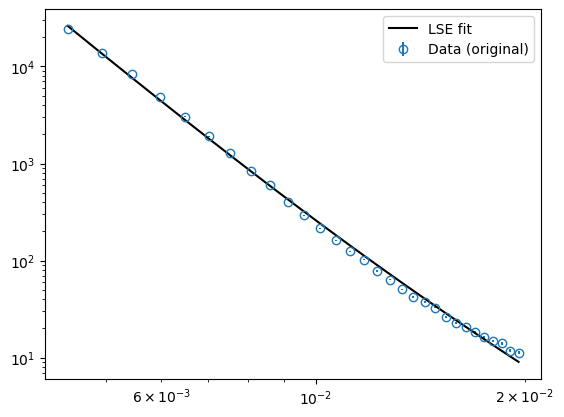

In [50]:

nobg_params = nobg_model.make_params(\
    aa=dict(value=2.3E-3, min=0.0),\
    kk=dict(value=0.02, min=0.001, max=0.05),\
    bb=dict(value=200.0, min=0.0),\
    cc=dict(value=1.0, min=0.0),\
           )

emodel_params = emodel.make_params(\
    aa=dict(value=23.0, min=0.0),\
    kk=dict(value=0.02),\
    bb=dict(value=200.0, min=0.0),\
    cc=dict(value=10.0, min=0.0),\
    bg=dict(value=1.0, min=0.0)\
           )

teubner_params = teubner_model.make_params(\
    bb=dict(value=200.0, min=0.0),\
    cc=dict(value=10.0, min=0.0),\
    bg=dict(value=10.0, min=0.0)\
           )

#result = teubner_model.fit(old_data[1], teubner_params, x=old_data[0], weights = 1.0/old_data[2])
#result = nobg_model.fit(old_data[1], nobg_params, x=old_data[0], weights = 1.0/old_data[2])
result = emodel.fit(old_data[1], emodel_params, x=old_data[0], weights = 1.0/old_data[2])

print(result.fit_report())

fig, ax = plt.subplots()
ax.errorbar(old_data[0], old_data[1], old_data[2], fmt='o', mfc='none', label="Data (original)")
#ax.plot(spec[0], result.init_fit, '--', color='black', label="LSE initial")
ax.plot(old_data[0], result.best_fit, color='black', label="LSE fit")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

ccval = result.params["cc"].value
bbval = result.params["bb"].value

zeta = (ccval * cscale) / (bbval * bscale)

# Affinescalarfunc has items nominal_value and std_dev:
cce = result.uvars["cc"].std_dev
bbe = result.uvars["bb"].std_dev

zetae = zeta * np.sqrt( (cce*cce / (ccval*ccval)) + (bbe*bbe / (bbval*bbval))  )

print("zeta:", zeta)
print("err:", zetae)

This implies also that the least squares algorithm in lmfit is different to the one in the other code.